In [1]:
from fastai.tabular.all import *
from fastai.collab import *

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [7]:
dls.show_batch()

,user,title,rating
0,86,Bean (1997),1
1,145,City Hall (1996),3
2,862,"Godfather, The (1972)",5
3,848,"Cook the Thief His Wife & Her Lover, The (1989)",1
4,347,Beavis and Butt-head Do America (1996),5
5,7,Heat (1995),3
6,782,Kull the Conqueror (1997),1
7,543,"Grifters, The (1990)",3
8,5,Jaws (1975),2
9,73,One Flew Over the Cuckoo's Nest (1975),5


In [8]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [9]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.882717,0.951206,00:10
1,0.689442,0.902430,00:11
2,0.549541,0.875995,00:10
3,0.454671,0.859651,00:12
4,0.452174,0.854242,00:11


In [10]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [11]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [12]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [13]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3453),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2774), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2744), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2704), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2682), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2573), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2565), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2565), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2531), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2379), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2358), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2342),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2282), 'Super Mario Bros. (1993)', 2.076923076923077),
 (tensor(-0.2154), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.211

In [14]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6291), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5517), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5405), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5269), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5140), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5084), 'Apt Pupil (1998)', 4.1),
 (tensor(0.5068), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5034), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4968), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4716), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4716), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4649), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4484), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4476), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4470), 'Vertigo (1958)', 4.251396648044692)]

In [15]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [16]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [17]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [18]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1454), 'Lawrence of Arabia (1962)'),
 (tensor(1.1048), 'When We Were Kings (1996)'),
 (tensor(1.0981), 'Close Shave, A (1995)'),
 (tensor(1.0687), 'Shall We Dance? (1996)'),
 (tensor(1.0287), 'Manchurian Candidate, The (1962)'),
 (tensor(1.0190), 'Chinatown (1974)'),
 (tensor(0.9993), 'Godfather, The (1972)'),
 (tensor(0.9862), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(0.9596), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(0.9583), 'Godfather: Part II, The (1974)')]

In [19]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1945), 'Batman & Robin (1997)'),
 (tensor(-1.1235), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0953), 'Jungle2Jungle (1997)'),
 (tensor(-1.0517), 'Speed 2: Cruise Control (1997)'),
 (tensor(-1.0516), 'Leave It to Beaver (1997)'),
 (tensor(-1.0374), "McHale's Navy (1997)"),
 (tensor(-1.0172), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-0.9411), 'Bio-Dome (1996)'),
 (tensor(-0.9053), 'Congo (1995)'),
 (tensor(-0.9033), 'Mouse Hunt (1997)')]

In [20]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [21]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9971), 'Dead Man (1995)'),
 (tensor(0.8616), 'To Die For (1995)'),
 (tensor(0.8567), 'Cook the Thief His Wife & Her Lover, The (1989)'),
 (tensor(0.8549), 'Trainspotting (1996)'),
 (tensor(0.8353), 'Crumb (1994)'),
 (tensor(0.8158), 'Cable Guy, The (1996)'),
 (tensor(0.8150), 'Showgirls (1995)'),
 (tensor(0.7903), 'Serial Mom (1994)'),
 (tensor(0.7815), 'Keys to Tulsa (1997)'),
 (tensor(0.7533), 'Beavis and Butt-head Do America (1996)')]

In [22]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1044), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0472), 'Braveheart (1995)'),
 (tensor(-1.0415), 'Titanic (1997)'),
 (tensor(-1.0074), 'Forrest Gump (1994)'),
 (tensor(-0.9713), 'Field of Dreams (1989)'),
 (tensor(-0.8633), 'Top Gun (1986)'),
 (tensor(-0.8612), 'Indiana Jones and the Last Crusade (1989)'),
 (tensor(-0.8516), 'Firm, The (1993)'),
 (tensor(-0.8394), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8128), 'Speed (1994)')]

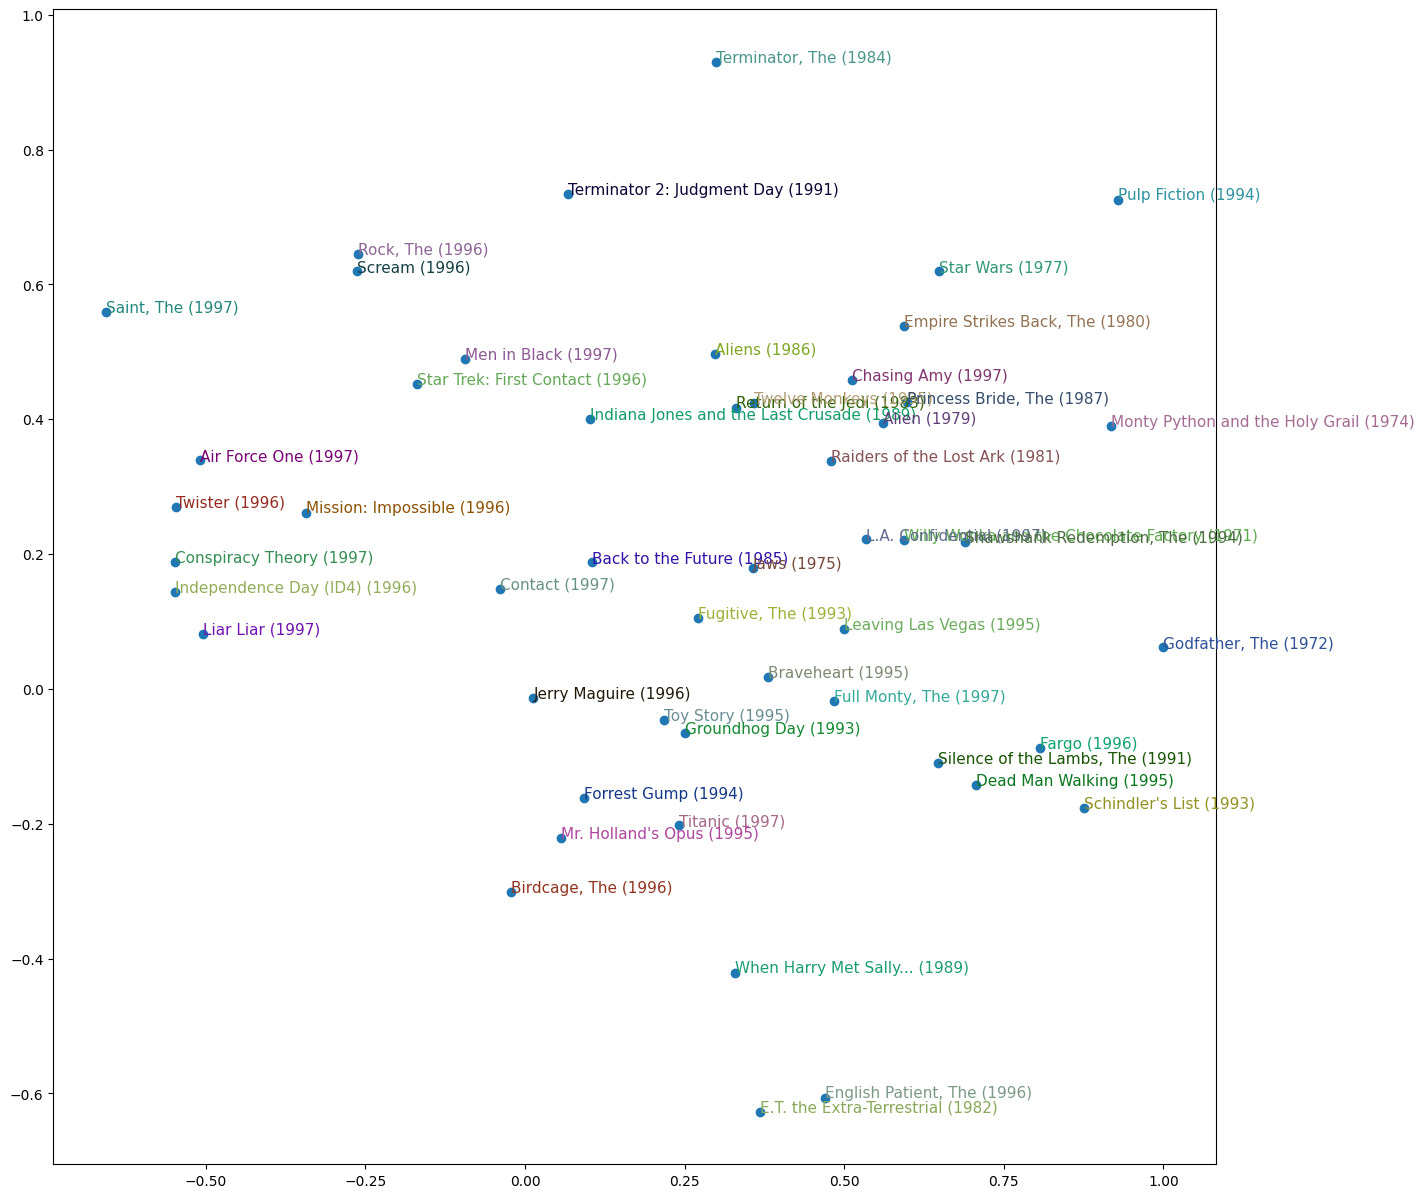

In [23]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()